In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [2]:
from IPython.display import display
import cobra
from cobra.io import read_sbml_model, write_sbml_model, save_json_model, load_json_model

In [ ]:
model = read_sbml_model('/Users/hellpark/Desktop/Bioinformatics September 2021/model_objects/Chalmers_Models/Chalmers_halov2.sbml')

# Measure the typical amount of glucose and oxygen consumed by the model

- Calculate glucose and ammonium uptake rate, then use model to calculate 1) growth rate 2) sugar consumption 3) oxygen consumption using sugar, nitrogen, oxygen supply at this time. 

- Quantity, calculated to get Vbiomass(t), V_PHA(t), VBioGlu and VBioOxy

In [3]:
def NH4GluOxytoBiomass(model, Vo2, MAX_glucose,MIN_glucose,MAX_nh4,MIN_nh4,mt_1,a,b):
    dummy = vo2/mt_1
    if (dummy) >= a:
        kglucose = MAX_glucose
        knh4 = MAX_nh4
        growth = 1
    elif (dummy) > b and (dummy) < a:
        kglucose = MAX_glucose - (-MIN_glucose+MAX_glucose)/(b-a)*(dummy-a)
        knh4 = MAX_nh4 - (-MIN_nh4+MAX_nh4)/(b-a)*(dummy-a)
        growth = 0
    elif (dummy) <= b:
        kglucose = MIN_glucose
        knh4 = MIN_nh4
        growth = 0

#after the determination of kGlucose and kAmonuim, 
#calculate the uptake rate of glucose and nitrogen
   
    Vglucose = kglucose*mt_1
    Vnh4 = knh4*mt_1

#Input parameters VGlucose(t), Vammonium(t) and VO2, metabolic network model, and m(t-1) 
#To synthesize biomass, it is necessary to calculate the amount of glucose
#consumed to maintain biomass without splitting.   
    
    set_bound(model, 'Exchange_Glucopyranose', ub = Vglucose)
    set_bound(model, 'Exchange_UREA', ub = Vnh4)
 #   set_bound(model, 'Exchange_OXYGEN-MOLECULE', ub = Vo2)
    s1 = model.optimize()
    Vbiomass_t = s1.objective_value
    VBioGlu = s1.get_primal_by_id('Exchange_Glucopyranose')
    VBioOxy = s1.get_primal_by_id('Exchange_OXYGEN-MOLECULE')
    
 #   print('model',f'{Vbiomass_t:.2f}','glucose:',f'{VBioGlu:.2f}','o2: ',f'{VBioOxy:.1f}')
    return Vbiomass_t, VBioGlu, VBioOxy, growth


### Use the remaining glucose and oxygen to bring into the metabolic network model to calculate the synthesis rate of PHA:
- Write the matlab function GluoxytoBiomass
- Input the parameters VGlucose(t) − VBioGlu, VO2 − VBioOxy and the metabolic network model, and calculate V-PHA(t).
- Finally, calculate the mass of biomass and PHA at this moment

In [6]:
def GluoxytoBiomass(model, glucose, oxygen, Vbiomass_t, mt_1, mpha_1, growth):
#calculate V-PHA(t)
    
    set_bound(model, 'Exchange_Glucopyranose', ub = glucose)
    set_bound(model, 'Exchange_OXYGEN-MOLECULE',ub = oxygen)
    
    VPHA_t, phag, phao = test_PHA_production(model)
    if VPHA_t is None or growth is 1:
        VPHA_t = .000001
    if Vbiomass_t is None:
        Vbiomass_t = .000001
    
#Finally, calculate the mass of biomass and PHA at this moment    
    mt = mt_1 + Vbiomass_t*0.9987244947
    mphat = mpha_1 + VPHA_t*0.086
    
    return mt, mphat, phag, phao


# Useful functions

In [ ]:
def set_yeast_extraction(model,ub=1000,lb=-1000):
    # given the evidence that TD01 strain can growth wihout supplyment of amino acids, 
    # the strain should be able to produce 20 amino acids by itself.
    # Block the uptake of 20 amino acids
    amino_acids = ['CYS_c','L-ASPARTATE_c','GLT_c','PHE_c','GLY_c',
                  'HIS_c','ILE_c','LYS_c','AMMONIA','LEU_c','MET_c','ASN_c',
                  'PRO_c','GLN_c','ARG_c','SER_c','THR_c','VAL_c',
                  'TRP_c','L-ALPHA-ALANINE_c','TYR_c','L-LACTATE','CPD-15990', 'ADENINE']
    for met_id in amino_acids:
        exg_rxn = model.reactions.get_by_id('Exchange_'+met_id.replace('_c',''))
        exg_rxn.upper_bound = ub
        exg_rxn.lower_bound = lb
        
def set_bound(model,rxn_id,lb=None,ub=None,eq=None):
    rxn = model.reactions.get_by_id(rxn_id)
    if lb is not None: rxn.lower_bound = lb
    if ub is not None: rxn.upper_bound = ub
    if eq is not None: 
        rxn.lower_bound = eq
        rxn.upper_bound = eq

def test_PHA_production(model):
#    set_yeast_extraction(model,ub=1,lb=0)
    pha_sink = cobra.Reaction('pha_sink')
    pha_sink.add_metabolites({model.metabolites.get_by_id('PHA_c'):-1})
    
    with model:
        model.add_reactions([pha_sink]) 
        model.objective = 'pha_sink'
        model.objective_direction = 'max'
        s1 = model.optimize()
        VphaGlu = s1.get_primal_by_id('Exchange_Glucopyranose')
        VphaOxy = s1.get_primal_by_id('Exchange_OXYGEN-MOLECULE')

    return s1.objective_value, VphaGlu, VphaOxy

# Main model

In [728]:
#condition set 1
mt_1 = 0.02
mpha_1 = 0.0
vo2 = 60.0
MAX_glucose = 10.0
MIN_glucose = 1.70
MAX_nh4 = 6.0
MIN_nh4 = 0.0
a = 10.0
b = 2.0
NGAM = 6.8
GAM = 53.95

In [752]:
model

Name,model_v1
Memory address,0x07f883110b470
Number of metabolites,2339
Number of reactions,2271
Number of groups,0
Objective expression,1.0*Biomass_v1 - 1.0*Biomass_v1_reverse_afb77
Compartments,"c, p, e"


In [712]:
model.reactions.NGAM.lower_bound = 6.8

In [636]:
df = pd.read_csv('/Users/hellpark/Desktop/Bioinformatics/model_objects/exp1.csv')
drycellmass = np.array(df['True cell mass']).astype(np.double)
phb = np.array(df['P3HB g/L']).astype(np.double)
t = np.array(df['time']).astype(np.double)

In [729]:
rgs = []
rgs2 = []
rgs3 = []
rgs4 = []
rgs5 = []
rgs6 = []
glcs = np.arange(0,50,1.0)

for glc in glcs:
    Vbiomass_t, VBioGlu, VBioOxy, growth = NH4GluOxytoBiomass(model, vo2, MAX_glucose,
                                                      MIN_glucose,MAX_nh4,
                                                      MIN_nh4,mt_1,a,b)
    
    #set bound back to start for next loop
    set_bound(model, 'Exchange_UREA', ub = MAX_nh4)

    mt, mpha, VphaGlu, VphaOxy = GluoxytoBiomass(model,MAX_glucose-VBioGlu,vo2-VBioOxy,
                               Vbiomass_t,mt_1,mpha_1, growth)
    set_bound(model, 'Exchange_OXYGEN-MOLECULE', ub = 1000)
    
    rgs.append(mt)
    rgs2.append(mpha)
    rgs3.append(VBioGlu)
    rgs4.append(VBioOxy)
    rgs5.append(VphaGlu)
    rgs6.append(VphaOxy)
    mt_1 = mt
    mpha_1 = mpha

/Users/hellpark/anaconda3/lib/python3.7/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


/Users/hellpark/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  app.launch_new_instance()


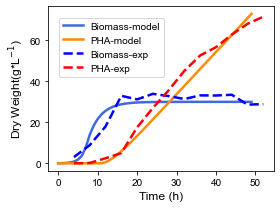

In [731]:
fig, ax1 = plt.subplots(figsize=(4,3))
rgs = np.array(rgs)
ax1.plot(glcs, rgs, color='royalblue',linestyle='solid', linewidth=2.5)
ax1.plot(glcs, rgs2, color='darkorange', linestyle='solid',linewidth=2.5)
ax1.plot(t, drycellmass, color='blue', linestyle='dashed',linewidth=2.5)
ax1.plot(t, phb, color='red', linestyle='dashed',linewidth=2.5)


ax1.set_ylabel('Dry Weight(g*L$^{-1}$)', size=12)
ax1.set_xlabel('Time (h)',size=12)
plt.rcParams["font.family"] = "arial"
#ax2.set_ylim([0,10])
fig.legend([rgs, rgs2], labels=['Biomass-model','PHA-model','Biomass-exp',
                                'PHA-exp'],bbox_to_anchor=(0.6, .92))

fig.tight_layout()
plt.savefig("/Users/hellpark/Desktop/Bioinformatics/model_objects/ferment_2.pdf")
plt.show()